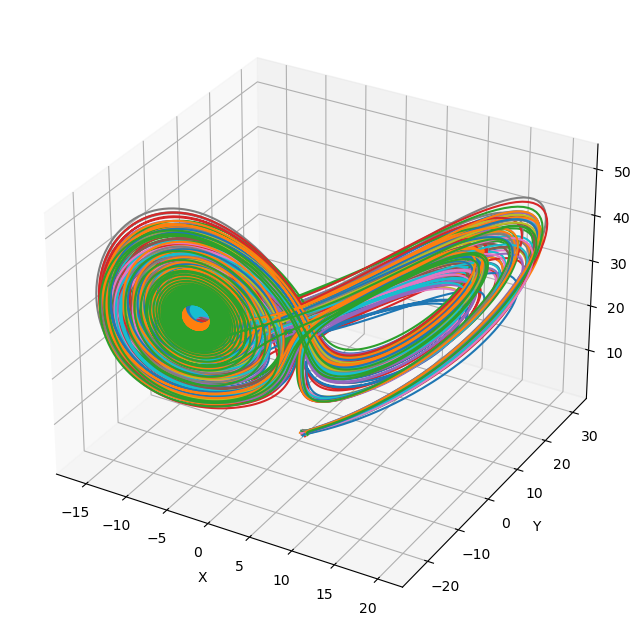

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import PRA as pra
import MVRA as mvra
import matplotlib.pyplot as plt
import mne
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns

#Sampling rate
sampling_rate = 250
#Number of samples
duration = 25


K = 1.0  # Coupling strength

# Number of oscillators is now 33, but there are 99 signals (x, y, z for each oscillator)
n_oscillators = 33
n_signals = n_oscillators * 3  # 99 signals

# Define the coupling matrix for the x components only
# Create a 33x33 coupling matrix for the x components
coupling_matrix = K * (np.ones((n_oscillators, n_oscillators)) - np.eye(n_oscillators))

# Expand this to a 99x99 matrix where only x components are coupled
ground_truth= np.zeros((n_signals, n_signals))
for i in range(n_oscillators):
    for j in range(n_oscillators):
        ground_truth[3*i, 3*j] = coupling_matrix[i, j]  # Place the coupling strength in the matrix

# Define random parameters for each oscillator
sigmas = np.random.normal(10, 1, n_oscillators)  # Mean 10, std deviation 2
rhos = np.random.normal(28, 2, n_oscillators)   # Mean 28, std deviation 4
betas = np.random.normal(2.66, 0.2, n_oscillators)  # Mean 2.66, std deviation 0.5

def coupled_lorenz(t, Y):
    Y = Y.reshape((n_oscillators, 3))
    dYdt = np.zeros_like(Y)
    
    for i in range(n_oscillators):
        x_i, y_i, z_i = Y[i]
        sum_coupled_x = np.sum(coupling_matrix[i] * (Y[:, 0] - x_i))
        
        dYdt[i, 0] = sigmas[i] * (y_i - x_i) + sum_coupled_x
        dYdt[i, 1] = x_i * (rhos[i] - z_i) - y_i
        dYdt[i, 2] = x_i * y_i - betas[i] * z_i
    
    return dYdt.flatten()

# Initial conditions for the 33 oscillators
initial_conditions = np.random.rand(n_signals)

# Time span for the simulation
t_span = (0, duration)  # from t=0 to t=25
t_eval = np.linspace(t_span[0], t_span[1], duration*sampling_rate)  # Evaluate the solution at 500 points

# Solve the system for the 33 oscillators with only x-component coupling
signals = solve_ivp(coupled_lorenz, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Verify the solution and output the full coupling matrix
signals.success, ground_truth


# Plot the solution
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(n_oscillators):
    ax.plot(signals.y[i*3], signals.y[i*3+1], signals.y[i*3+2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()




In [2]:
## simulated data
ch_names = ["Ch{}".format(i+1) for i in range(n_signals)]

#ch_names = ["A", "B", "C"]
#sim_data = np.array([solution.y[1], solution.y[4], solution.y[7]])
sim_data = np.array(signals.y)
#sim_data = np.array(solution.y[:10])
info = mne.create_info(ch_names=ch_names, ch_types=["eeg"]*n_signals, sfreq=sampling_rate)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=25.0)

Creating RawArray with float64 data, n_channels=99, n_times=6250
    Range : 0 ... 6249 =      0.000 ...    24.996 secs
Ready.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


In [3]:
#PRA
pra_mat = pra.PRA(epochs.get_data(),sampling_frequency=sampling_rate,num_reservoir=10)

#MVRA
mvra_mat = mvra.MVRA(epochs.get_data(),sampling_frequency=sampling_rate,num_reservoir=3)

Using data from preloaded Raw for 1 events and 6250 original time points ...
0 bad epochs dropped


  0%|          | 0/1 [00:00<?, ?it/s]

Using data from preloaded Raw for 1 events and 6250 original time points ...


  0%|          | 0/1 [00:00<?, ?it/s]

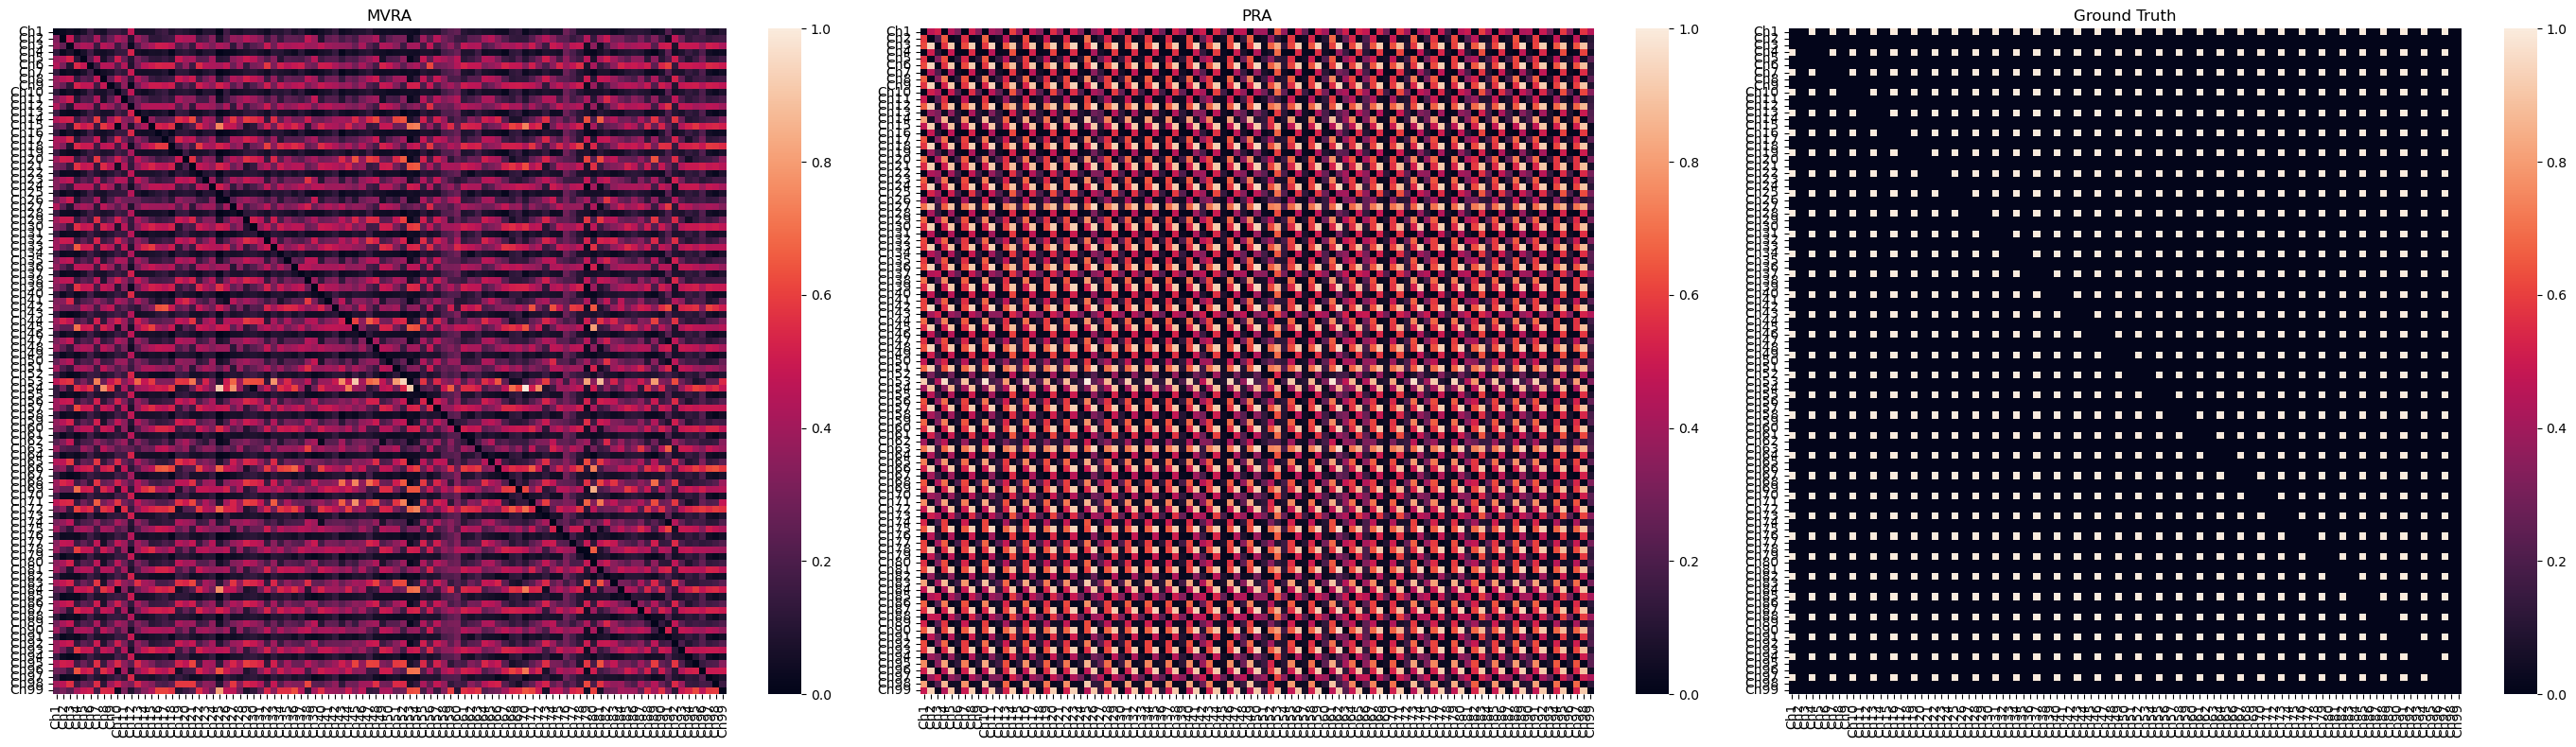

In [4]:
ch_names = ["Ch{}".format(i+1) for i in range(99)]
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(28,8))
sns.heatmap(mvra_mat.squeeze(), annot=False, xticklabels=ch_names, yticklabels=ch_names, ax=ax1)
ax1.set_title('MVRA')

sns.heatmap(pra_mat, annot=False, xticklabels=ch_names, yticklabels=ch_names, ax=ax2)
ax2.set_title('PRA')

# Plotting the ground truth connectivity matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(ground_truth, annot=False, xticklabels=ch_names, yticklabels=ch_names, ax=ax3)
ax3.set_title('Ground Truth')

fig.tight_layout()
plt.savefig('lorenz_data_all_time.pdf')